WNixalo | 20181111

---



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Data

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [4]:
df = pd.read_csv(path/'train_v2.csv')

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

**Note**: Lesson 2 @ [[24:41](https://youtu.be/Egp4Zajhzog?t=1481)]

JHoward always sets the random seed before creating a dataset with a random validation set. This ensures the same validation set every time the code is run.

This isn't to make the ML experiments reproducible with identical results each time: the randomness is important to determining the stability of a result (will it work every time?). Instead, what's important is to make sure you have the same validation set.

This way, you can judge if a hyperparameter change improves a model; otherwise the new random set of data may just be easier or harder than last time.

I did not set that here. 

In [6]:
# np.random.seed(0)

In [7]:
src = (ImageFileList.from_folder(path)
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2))

In [8]:
data = (src.datasets()
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

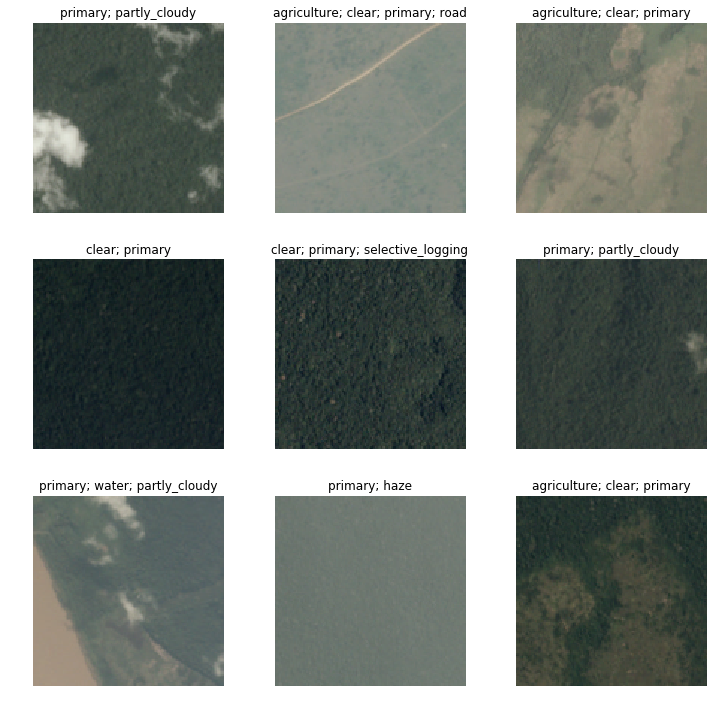

In [10]:
data.show_batch(rows=3, figsize=(10,10))

## MultiClass

Working on ResNet50

In [9]:
arch = models.resnet50

a threshold of 0.25 got me best results last time, so I'll see if putting that will help get more accurate metrics.

Also the updated course notebook defines the metrics a bit differently, so updating that.

In [10]:
acc_025 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn   = create_cnn(data, arch, metrics=[acc_025, f_score])

### Stage 1 size 128

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


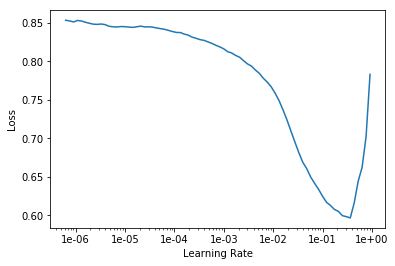

In [14]:
learn.lr_find()
learn.recorder.plot()

In [11]:
lr = 0.01

In [16]:
learn.fit_one_cycle(5, slice(lr))

Total time: 09:09
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.118385    0.104975    0.953282         0.904826  (01:50)
2      0.108861    0.098018    0.954656         0.914298  (01:49)
3      0.098181    0.094003    0.957454         0.915341  (01:49)
4      0.094953    0.086935    0.960593         0.921822  (01:50)
5      0.090371    0.085242    0.962039         0.924845  (01:50)



In [17]:
learn.save('stage-1-rn50')

In [18]:
learn.fit_one_cycle(5, slice(lr))

Total time: 09:08
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.096114    0.089868    0.961167         0.920002  (01:48)
2      0.100768    0.092226    0.959866         0.917010  (01:49)
3      0.098078    0.089618    0.962736         0.920924  (01:50)
4      0.092254    0.085683    0.961494         0.923920  (01:50)
5      0.085045    0.083881    0.962206         0.925967  (01:50)



hasn't started to overfit yet – for future note.

In [19]:
learn.save('stage-1-rn50')

### Stage 2 size 128

**Note**: Learning Rate Finder - Lesson 2 @ [[27:46](https://youtu.be/Egp4Zajhzog?t=1666)]
> On the learning rate finder, what you'r elooking for is the strongest downward slope, that's kind of sticking around for quite a while.

If you're not sure which slope is better, try both and see. And pick the steeper part. When unfreezing, that's for the first part of the learning rates. For the later part, generally `1e-4` to `3e-4` tends to work pretty well.

In [20]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


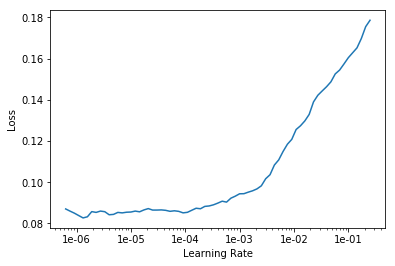

In [21]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 12:01
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.091857    0.091112    0.955339         0.918024  (02:22)
2      0.094029    0.089000    0.959685         0.920413  (02:24)
3      0.089163    0.085623    0.959103         0.924597  (02:24)
4      0.084393    0.082968    0.962889         0.925932  (02:24)
5      0.082152    0.082306    0.962584         0.927510  (02:25)



In [25]:
learn.save('stage-2-rn50')

In [26]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 12:37
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.084482    0.086046    0.960593         0.922745  (02:23)
2      0.088798    0.088681    0.956633         0.917831  (02:24)
3      0.083969    0.086042    0.962112         0.922684  (02:30)
4      0.081281    0.082569    0.961995         0.927868  (02:39)
5      0.074530    0.082094    0.961530         0.927722  (02:39)



I'm not sure this got better, accuracy is about the same, although the validation loss has dropped a bit. I'll save both. *(looks like training more was better)*

In [28]:
learn.save('stage-2-rn50_extra')

In [12]:
learn = learn.load('stage-2-rn50_extra')

### Stage 1 size 256

Have to lower the batch size with an RN50. This'll get even lower when the layers are unfrozen.

In [13]:
learn.data.train_dl.batch_size

64

In [14]:
data = (src.datasets()
        .transform(tfms, size=256)
        .databunch(bs=48).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [15]:
learn.data.train_dl.batch_size

48

In [16]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


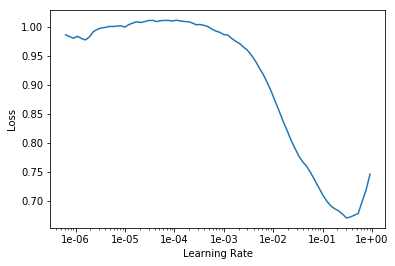

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 1e-2/2

In [19]:
learn.fit_one_cycle(5, slice(lr))

Total time: 32:46
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.098740    0.084433    0.962148         0.923887  (06:36)
2      0.089382    0.084169    0.965243         0.922516  (06:32)
3      0.090661    0.079688    0.963282         0.929144  (06:31)
4      0.083093    0.079137    0.964779         0.927973  (06:32)
5      0.083255    0.078100    0.963398         0.929814  (06:32)



In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.recorder.plot_losses()

### Stage 2 size 256

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-256-rn50')

In [ ]:
learn.recorder.plot_losses()

**NOTE** Discriminative Learning rates: fast.ai Lesson 2 [1:24:01](https://www.youtube.com/watch?v=BWWm4AzsdLk&feature=youtu.be&t=5038)
- slice: python keyword. evenly distributes vals from start up to stop.
- Stage 2: `max_lr` slice: 1st val from LR Finder well before loss deteriorates; 2nd val abt 10x less than Stage 1 LR.

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50_1')

## Test set

In [ ]:
# learn.load('stage-2-256-rn34_1') # extra training
learn.load('stage-2-256-rn50')

In [ ]:
idx2class = idx2class = {v:k for k,v in learn.data.train_ds.ds.class2idx.items()}

In [ ]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [ ]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .datasets(ImageMultiDataset)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st dataset portion

In [ ]:
set_test_datafolder(learn, 'test-jpg')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
len(raw_preds), raw_preds[0].shape, raw_preds[1].shape

In [ ]:
preds = copy(raw_preds)

In [ ]:
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.ds.x]

2nd dataset portion

In [ ]:
set_test_datafolder(learn, 'test-jpg-additional')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
preds = (torch.cat((preds[0],raw_preds[0])), torch.cat((preds[1],raw_preds[1])))

In [ ]:
# # NOTE: this will work:
# preds = [torch.cat((preds[i],raw_preds[i])) for i in range(len(preds))]

# # but this will leave you with a <generator object <genexpr> at 0x7f91696821a8>
# preds = (torch.cat((preds[i],raw_preds[i])) for i in range(2))

In [ ]:
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.ds.x])

## Submitting predictions to Kaggle

In [ ]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [ ]:
th = 0.3

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [ ]:
sub_name = f'planet_stage-2-256-rn50_{date}_th{str(th)}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "fastai 1.0; 2-stg; RN34; threshold="{th}

threshold|pvt score|rank
-|-|-

I may go to resnet50.

### Aside:

I don't know how to interpret the 2nd array of `learn.TTA()`'s output,since it's the same for all inputs, independent of output probability. It's supposed to be the actual label I think; so then it's just a dummy value, but then again: why are the first 2 tensors '1' and the rest '0'?

In [ ]:
prob = preds[0][1]
pred = preds[1][1]

In [ ]:
for i in zip(prob, pred): print(i)

In [ ]:
temp = []

In [ ]:
for i in range(len(preds[1])):
    for j in range(len(preds[1][i])):
        if preds[1][i][j]==1: temp.append(j)

In [ ]:
np.unique(np.array(temp))

## end